In [ ]:
!pip install tokenizers

     |████████████████████████████████| 6.8 MB 14.0 MB/s 


In [ ]:
import sys
### Direct this path to the appropriate folder for importing libaries
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Newspaper Classification')


Mounted at /content/drive


In [ ]:
import pandas as pd
import glob
from tqdm import tqdm
import re
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score,f1_score,precision_score,accuracy_score
import torch
from torch import nn


#Load data

In [ ]:
finale_dataframe = pd.read_csv("/content/drive/MyDrive/Newspaper Classification/Data/version_1_punctuation_13-11-2021.csv",encoding="utf8")

In [ ]:
finale_dataframe=finale_dataframe[~finale_dataframe['label'].str.contains("po")]
len(finale_dataframe)

200000

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(
                                                    finale_dataframe.drop("label", axis=1),
                                                    finale_dataframe["label"], 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42, 
                                                    stratify = finale_dataframe["label"]
                                                    )

X_valid, X_test, y_valid, y_test = train_test_split(
                                                    X_test,
                                                    y_test, 
                                                    test_size=0.5, 
                                                    shuffle=True, 
                                                    random_state=42, 
                                                    stratify = y_test
                                                    )

In [ ]:
print(y_train.value_counts())
print(y_test.value_counts())
print(y_valid.value_counts())


st    32000
hp    32000
sp    32000
ed    32000
ec    32000
Name: label, dtype: int64
ec    4000
hp    4000
sp    4000
ed    4000
st    4000
Name: label, dtype: int64
ec    4000
hp    4000
sp    4000
ed    4000
st    4000
Name: label, dtype: int64


18.261546791407994


(array([4.85957e+05, 3.31820e+05, 6.32002e+05, 7.60495e+05, 6.23002e+05,
        4.07057e+05, 2.35326e+05, 1.28390e+05, 6.88070e+04, 3.77430e+04,
        2.08770e+04, 1.20310e+04, 7.35900e+03, 4.46500e+03, 3.00800e+03,
        1.98700e+03, 1.35600e+03, 9.95000e+02, 7.22000e+02, 5.08000e+02,
        3.99000e+02, 2.94000e+02, 2.33000e+02, 1.81000e+02, 1.31000e+02,
        1.14000e+02, 9.10000e+01, 8.20000e+01, 5.90000e+01, 4.40000e+01,
        5.90000e+01, 3.30000e+01, 2.80000e+01, 3.10000e+01, 1.90000e+01,
        1.90000e+01, 1.60000e+01, 1.00000e+01, 1.10000e+01]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
        195]),
 <a list of 39 Patch objects>)

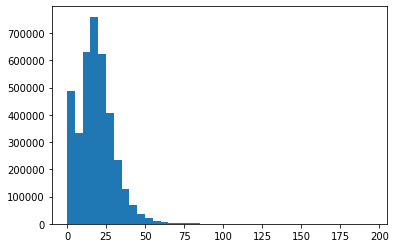

In [ ]:
lst = []
for _,x in X_train.iterrows():
    lst.extend(x["data"].split("."))
lens = [len(x.split(" ")) for x in lst]
 
print(sum(lens)/len(lens))
plt.hist(lens, bins = list(range(0, 200,5)))

23.53670625


(array([7.3120e+03, 1.1922e+04, 2.9028e+04, 3.1176e+04, 2.4765e+04,
        1.6847e+04, 1.1258e+04, 7.8930e+03, 5.3430e+03, 3.8140e+03,
        2.7130e+03, 2.1560e+03, 1.4870e+03, 1.0800e+03, 7.8200e+02,
        5.6800e+02, 4.2300e+02, 3.2800e+02, 2.4700e+02, 1.7500e+02,
        1.1700e+02, 1.0200e+02, 6.1000e+01, 5.8000e+01, 3.8000e+01,
        5.0000e+01, 2.8000e+01, 1.5000e+01, 2.3000e+01, 1.6000e+01,
        1.3000e+01, 2.4000e+01, 1.1000e+01, 1.3000e+01, 6.0000e+00,
        6.0000e+00, 8.0000e+00, 1.0000e+00, 5.0000e+00]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
        130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
        195]),
 <a list of 39 Patch objects>)

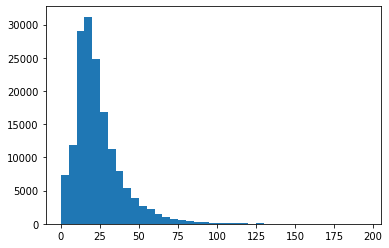

In [ ]:
lens = [len(x["data"].split(".")) for _,x in X_train.iterrows()]
print(sum(lens)/len(lens))
plt.hist(lens, bins = list(range(0, 200,5)))


##Load unseen test

In [ ]:
unseen_test = pd.read_csv("/content/drive/MyDrive/Newspaper Classification/Data/unseen_test_punctuation_v1_3-12-2021.csv",encoding = "utf8")

In [ ]:
unseen_test=unseen_test[~unseen_test['label'].str.contains("po")]
len(unseen_test)

5000

#Initializing data loader

In [ ]:
import numpy as np
def filterLen(x):
    if len(x.split(" ")) > 2:
        return True
    return False
def split_conversation(X,y):
    label = ["ec","hp","ed","sp","st"]
    x_data = []
    y_data = []
    for i in range(0,len(X)):
        X_mold = X["data"].iloc[i].split(".")
        X_mold = filter(filterLen, X_mold)
        x_data.append(list(X_mold))
        y_data.append(label.index(y.iloc[i]))
    return x_data, y_data

In [ ]:
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader

class DADataset(Dataset):
    
    def __init__(self, tokenizer, text, label, max_len=50):
        
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        
        sentences = self.text[index]
        labels = self.label[index]

        # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

        # For every sentence...
        for sent in sentences:
            # `encode_plus` will:
            #   (1) Tokenize the sentence.
            #   (2) Prepend the `[CLS]` token to the start.
            #   (3) Append the `[SEP]` token to the end.
            #   (4) Map tokens to their IDs.
            #   (5) Pad or truncate the sentence to `max_length`
            #   (6) Create attention masks for [PAD] tokens.
            encoded_dict = tokenizer.encode(sent)
                        
            # Add the encoded sentence to the list.    
            input_ids.append(encoded_dict.ids)
            

        # Convert the lists into tensors.
        input_ids = torch.tensor(input_ids)
        if(len(input_ids)>self.max_len):
            input_ids = input_ids[:self.max_len,:]
        else:
            mold = torch.zeros(self.max_len, 50,dtype=int)
            mold[:len(input_ids),:] = input_ids
            input_ids = mold
        labels = torch.tensor(labels)
        
        return {
            "input_ids":input_ids,
            "label":labels,
        }


In [ ]:

from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers
from tokenizers import ByteLevelBPETokenizer
def train_tokenizer(corpus):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train_from_iterator(corpus, vocab_size=50000, min_frequency=10, special_tokens=["[PAD]","[UNK]"])
    tokenizer.enable_padding(direction='right', length=50, pad_id=tokenizer.get_vocab()['[PAD]'])
    tokenizer.enable_truncation(max_length=50)
    return tokenizer

In [ ]:
tokenizer=train_tokenizer(X_train["data"])

In [ ]:
tokenizer.save("/content/drive/MyDrive/Newspaper Classification/Model-without Politics/HAN/tokenizer.json")

In [ ]:
tokenizer = Tokenizer.from_file("/content/drive/MyDrive/Newspaper Classification/Model-without Politics/HAN/tokenizer.json")

In [ ]:
moldx, moldy =split_conversation(X_train,y_train)
train_dataset = DADataset(tokenizer=tokenizer, text = moldx, label = moldy, max_len=40)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)

In [ ]:
moldx, moldy =split_conversation(X_valid,y_valid)
val_dataset = DADataset(tokenizer=tokenizer, text = moldx, label = moldy, max_len=40)
val_loader = DataLoader(dataset=val_dataset, batch_size=100, shuffle=False, drop_last=True)

In [ ]:
moldx, moldy =split_conversation(X_test,y_test)
test_dataset = DADataset(tokenizer=tokenizer, text = moldx, label = moldy, max_len=40)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False, drop_last=True)

In [ ]:
moldx, moldy =split_conversation(unseen_test,unseen_test["label"])
unseen_dataset =DADataset(tokenizer=tokenizer, text = moldx, label = moldy, max_len=40)
unseen_loader = DataLoader(dataset=unseen_dataset, batch_size=100, shuffle=False, drop_last=True)

In [ ]:
len(train_loader), len(val_loader), len(test_loader), len(unseen_loader)

(2500, 200, 200, 50)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Word_RNN(nn.Module):
    
    def __init__(self,device,vocab,embedding_size = 300, model_name="bert-base-uncased", hidden_size=128, bidirectional=True, num_layers=1):
        super(Word_RNN, self).__init__()
        
        self.device = device
        # embedding layer 
        self.embedding = nn.Embedding(vocab, embedding_size)
        self.embedding_size = embedding_size
        self.rnn = nn.GRU(
            input_size=embedding_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            bidirectional=bidirectional,
            batch_first=True
        )
        self.hidden_size = hidden_size
    def forward(self, input_ids):
        """
            x.shape = [batch_size, sentence,seq_len]
        """
        features = self.embedding(input_ids)
        hidden = torch.empty((0,input_ids.shape[1], input_ids.shape[2],self.hidden_size*2)).to(self.device)
        for i in range(0,input_ids.shape[0]):
            outputs, _ = self.rnn(features[i])
            outputs = outputs.unsqueeze(0)
            hidden = torch.cat((hidden, outputs), dim=0).to(self.device)
        return hidden

In [ ]:
class WordAttention(nn.Module):

    def __init__(self, hidden_size=128*2):
        super(WordAttention, self).__init__()
        
        self.context = nn.Linear(in_features=hidden_size, out_features=1, bias=True)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()
        
    def forward(self, hidden_states):
       
        energy = self.tanh(self.context(hidden_states))
        
        attention = self.softmax(energy)
        
        m = torch.mul(attention,hidden_states)
        m = torch.sum(m,dim=-2)
        return m

In [ ]:
class SentenceAttention(nn.Module):

    def __init__(self, hidden_size=64*2):
        super(SentenceAttention, self).__init__()
        
        self.context = nn.Linear(in_features=hidden_size, out_features=1, bias=True)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, hidden_states):
       
        energy = self.tanh(self.context(hidden_states))
        
        attention = self.softmax(energy)
        
        m = torch.mul(attention,hidden_states)
        m = torch.sum(m,dim=-2)
        return m

In [ ]:
class HAN(nn.Module):
    
    def __init__(self, vocab_size,hidden_size=768, num_classes=5, device=device):
        super(HAN, self).__init__()
        self.device = device
        self.wordatt = WordAttention().to(self.device)
        self.wordgru = Word_RNN(self.device,vocab_size).to(self.device)
        self.sentenceatt = SentenceAttention().to(self.device)
        self.sentencegru = nn.GRU(
            input_size=256, 
            hidden_size=64, 
            num_layers=1, 
            bidirectional=True,
            batch_first=True
        ).to(self.device)
        self.classifier = nn.Sequential(*[
            nn.Linear(in_features=128, out_features=num_classes),
            nn.LeakyReLU(),
            nn.Softmax(dim=-1)
        ]).to(self.device)
    
    def forward(self, inputs):  

        x = self.wordgru(inputs).to(self.device)
        x = self.wordatt(x)
        outouts,_ = self.sentencegru(x)
        x = self.sentenceatt(outouts)
        # Xuất kết quả phân loại
        return self.classifier(x)

In [ ]:
model = HAN(tokenizer.get_vocab_size(),device=device)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Newspaper Classification/Model-without Politics/HAN/HAN_unseen_continue.pth"))

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Newspaper Classification/Model-without Politics/HAN/HAN.pth"))

<All keys matched successfully>

In [ ]:
def evaluate(model, data_loader):
    accuracies = []
    losses = []
    model.eval()
    with torch.no_grad():
        for x in data_loader:
            # Forward pass
            targets = x["label"].to(device)
            outputs = model(x["input_ids"].to(device))
            loss = loss_function(outputs, targets)

            accuracy = (outputs.argmax(dim=-1) == targets).type(torch.float32).mean().item()
            accuracies.append(accuracy)
            losses.append(loss.item())
    
    return np.mean(losses), np.mean(accuracies)

In [ ]:
def results(model, data_loader):
    result = []
    model.eval()
    with torch.no_grad():
        for x in data_loader:
            # Forward pass
            outputs = model(x["input_ids"].to(device))
            outputs = torch.argmax(outputs,-1)
            result.extend(outputs.tolist())
    return result


In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.00001, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 2x every 10 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.5)
loss_function = nn.CrossEntropyLoss().to(device)

In [ ]:
n_batch = len(train_loader)
max_acc = 0

In [ ]:
_,max_acc = evaluate(model, val_loader)

In [ ]:
max_acc

0.971549968123436

In [ ]:

train_accs = []
train_losses = []
test_accs = []
test_losses = []
for epoch in range(4):
    model.train()
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}")
        for batch_idx, x in enumerate(tepoch):

            targets = x["label"].to(device)

            #forward
            logits = model(x["input_ids"].to(device))
            #print(torch.argmax(logits,dim=1))
            loss = loss_function(logits, targets)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            train_accs.append((logits.argmax(dim=-1) == targets).type(torch.float32).mean().item())
            train_losses.append(loss.item())

            tepoch.set_postfix(loss=train_losses[-1], acc=train_accs[-1])

            if batch_idx >= n_batch - 1:
                val_loss, val_acc =  evaluate(model, val_loader)
                test_losses.append(val_loss)
                test_accs.append(val_acc)
                tepoch.set_postfix(loss=np.mean(train_losses), acc=np.mean(train_accs), val_loss=val_loss, val_acc=val_acc)

    if max_acc < val_acc:
        max_acc = val_acc
        print(f"Save at epoch={epoch+1} with lr={lr_scheduler.get_last_lr()} and loss={val_loss}")
        torch.save(model.state_dict(), "/content/drive/MyDrive/Newspaper Classification/Model-without Politics/HAN/HAN.pth")

Epoch 4:  78%|███████▊  | 1955/2500 [42:55<11:58,  1.32s/batch, acc=1, loss=0.905]

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Newspaper Classification/Model-without Politics/HAN/HAN_unseen_continue_continue.pth")

#Result

In [ ]:
_,max_acc = evaluate(model, train_loader)
max_acc

0.98798125

In [ ]:
_,max_acc = evaluate(model, val_loader)
max_acc

0.971549968123436

In [ ]:
_,max_acc = evaluate(model, unseen_loader)
max_acc

0.8915999817848206

In [ ]:
pred_res = results(model, unseen_loader)

In [ ]:
pred_res

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [ ]:
def indexToRes(result):
    res = list(result)
    label = ["ec","hp","ed","sp","st"]
    ret = []
    for i in range(0,len(res)):
        ret.append(label[int(res[i])])
    return ret

In [ ]:
y_pred=indexToRes(pred_res)

In [ ]:
cm = confusion_matrix(y_pred,unseen_test["label"],labels=["ec","hp","ed","sp","st"])

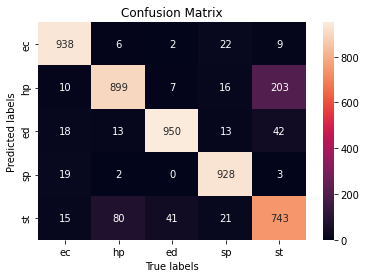

In [ ]:

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(["ec","hp","ed","sp","st"]); ax.yaxis.set_ticklabels(["ec","hp","ed","sp","st"]);